## ANNOY Structure \& KDE

In [ ]:
def load_annoy_structure(X, num_trees = 10):
    # X: a (samples x features) data matrix
    # num_trees: number of trees within the forest. 
    #     - More trees gives higher precision when querying, but will take a longer time to return.
    
    import numpy as np
    from annoy import AnnoyIndex
    import scipy.spatial.distance as distance 
    
    X = np.array(X);
    [n,D] = X.shape;

    t = AnnoyIndex(D, 'euclidean') # Length of item vector that will be indexed
    for i in range(n):
        t.add_item(i, X[i,:]) 

    t.build(num_trees) 
    return t

In [2]:
def query_annoy_structure(annoy_struct,idx, k=1):
    # annoy_struct is a nearest neighbor search structure built using the Spotify Annoy toolbox. 
    # k reflects the number of nearest neighbors to search for.
    
    from annoy import AnnoyIndex
    
    v = annoy_struct.get_nns_by_item(idx,k+1, include_distances=True)
    indices   = v[0][1:];
    distances = v[1][1:];
    return indices, distances

In [30]:
def KDE(X, H):
    import scipy
    import time
    
    n = len(X);
    
    tic = time.perf_counter()
    XTree = load_annoy_structure(X);
    NQ = H['NQueries'];
    # Compute density, stored as p:
    p = np.zeros((n,1))
    idx_NN = []
    D_NN = []
    for i in range(n):
        idx,D = query_annoy_structure(XTree,i,  k=NQ)
        p[i] = np.exp(-np.square(np.array(D)[1:])/(H['Sigma0']**2)).sum()
        idx_NN.append(idx)
        D_NN.append(D)
        
        if i%25000 == 0:
            toc = time.perf_counter()
            print('Density calculation, '+str(round(100*i/n))+'% complete. Time Elapsed: '+ str(round(toc-tic))+ ' s.')

    p = p/sum(p)
    print('Density calculated. Time Elapsed: '+ str(round(toc-tic))+ ' s.')
    idx_NN = np.asarray(idx_NN)
    D_NN = np.asarray(D_NN)

    return p, idx_NN, D_NN

## Extract Graph

In [4]:
def extract_graph(X, H):
    
    import time
    from sklearn import neighbors
    from scipy import sparse
    print('Constructing graph...')
    
    tic = time.perf_counter();
    n = len(X);

    # Build adjesency matrix
    W = neighbors.kneighbors_graph(X, H['DiffusionNN']);
    toc = time.perf_counter();

    if toc-tic<60:
        print('Graph calculated. Time Elapsed: '+ str(round(toc-tic))+ ' s.')
    else:
        print('Graph calculated. Time Elapsed: '+ str(round((toc-tic)/60),2)+ ' minutes.')

            
    print('Performing eigendecomposition for diffusion map...')

    # Normalize so that each row sums to 1. Take eigendecomposition:
    D,V =  sparse.linalg.eigs(sparse.spdiags(1/W.sum(axis = 1).T, 0, len(X),len(X))*W, k=H['NEigs'])
    
    # Normalize and sort eigenvalues/eigenvectors:
    D = np.absolute(D);
    D = np.sort(D)[::-1]
    V = np.real(V[:,np.argsort(D)[::-1]])
    D[0] = 1;
    V[:,0]=1;
    
    # Compute Diffusion Map:
    DiffusionMap = np.zeros((n,H['NEigs']))
    for i in range(H['NEigs']):
        DiffusionMap[:,i] = (D[i]**H['DiffusionTime'])*V[:,i];
        
    toc = time.perf_counter()
    if toc-tic<60:
        print('Diffusion Map calculated. Time Elapsed: '+ str(round(toc-tic))+ ' s.')
    else:
        print('Diffusion Map calculated. Time Elapsed: '+ str(round((toc-tic)/60),2)+ ' minutes.')

    
    return DiffusionMap, V, D

In [34]:
def extract_graph_large_matlab(X, H, idx, d):
    print('Constructing graph and performing eigendecomposition for diffusion map...')
    ones = np.ones((len(X), H['NQueries']))
    idx = idx+ones
    
    import matlab.engine
    eng = matlab.engine.start_matlab()

    import time
    tic = time.perf_counter();
    V, D = eng.extract_graph_large(matlab.double(X.tolist()), H, 
                                   matlab.double(idx.tolist()), matlab.double(d.tolist()), nargout=2);
    V = np.asarray(V)
    D = np.asarray(D)
    
    n = len(X);
    DiffusionMap = np.zeros((n,H['NEigs']))
    for i in range(H['NEigs']):
        DiffusionMap[:,i] = (D[i]**H['DiffusionTime'])*V[:,i];
        
    toc = time.perf_counter();
    
    if toc-tic<60:
        print('Graph and Diffusion Map calculated. Time Elapsed: '+ str(round(toc-tic))+ ' s.')
    else:
        print('Graph and Diffusion Map calculated. Time Elapsed: '+ str(round((toc-tic)/60),2)+ ' minutes.')
        
        
    return DiffusionMap, V, D

## $\rho_t$ Calculation \& LUND Labeling

In [5]:
def rho_t(X, p, H):

    import time
    import math
    import scipy
    import sklearn

    tic = time.perf_counter()
    n = len(X);

    XTree = load_annoy_structure(X) 

    # Compute rho_t(x), stored as r:
    r = np.zeros((n,1))
    p_max = max(p);
    for i in range(n):

        if p[i] < p_max:
        
            idx,D = query_annoy_structure(XTree,i,  k=H['NQueries'])

            mask = (p[idx]>p[i]).T.tolist()[0];

            if sum(mask)>0:

                i_star = np.array(idx)[mask][0] # Nearest neighbor of higher density
                r[i] = np.linalg.norm(X[i_star,:]-X[i,:])
            else:

                idx,D = query_annoy_structure(XTree,i,  k=5*H['NQueries'])

                mask = (p[idx]>p[i]).T.tolist()[0];
                if sum(mask)>0:

                    i_star = np.array(idx)[mask][0] # Nearest neighbor of higher density
                    r[i] = np.linalg.norm(X[i_star,:]-X[i,:])
                else:

                    r[i] = sklearn.metrics.pairwise_distances(np.array([list(X[i,:])]), X[(p>p[i]).T.tolist()[0],:]).max();


            if i%25000 == 0:
                toc = time.perf_counter()
                print('rho_t calculation, '+str(math.floor(i/n*100))+'% complete. Time Elapsed: '+ str(round(toc-tic))+ ' s.')
        else:
            r[i] = np.nan
            
    r[np.isnan(r)] = max(r)*10;    
    toc = time.perf_counter()

    print('rho_t calculation complete. Time Elapsed: '+ str(round(toc-tic))+ ' s.')
    return r

In [6]:
def LUND_label(r, p, H, DiffusionMap):

    import time
    import math
    import scipy
    import sklearn

    tic = time.perf_counter()
    n = len(p);
    idces = np.linspace(0,n-1,n); 
    
    Dt = r*p;
    m_sorting = list(np.argsort(np.array(Dt.T.tolist()[0])))[::-1];
    vec = Dt[m_sorting[:-1]]/Dt[m_sorting[1:]];
    vec[vec == np.inf] = np.nan;
    K = np.nanargmax(vec) +1 ;    
        
    # Compute K
    if 'Kknown' in H:
        K = H['Kknown']

    if K == 1:
        C = np.ones((n,1));
    else:

        Psi_Tree = load_annoy_structure(DiffusionMap) 
        l_sorting = list(np.argsort(np.array(p.T.tolist()[0])))[::-1];

        # Compute clustering, stored as C:
        C = np.zeros((n,1))
        
        # Label modes 
        for i in range(K):
            C[m_sorting[i]] = i+1;
                
        # Label non-modal points in order of decreasing density.
        for j in range(n):
            
            i = l_sorting[j];

            if C[i] == 0:
                
                # We compute the index of the Dt-nearest neighbor of xi that is higher density and already labeled.

                idx,D = query_annoy_structure(Psi_Tree, i,  k=2*H['NQueries'])

                mask1 = np.array((p[idx]>p[i]).T.tolist()[0]); # Points with higher density in the nearest neighbor search
                mask2 = np.array((C[idx]>0).T.tolist()[0]);    # Points that are already labeled in the nearest neighbor search
                mask = mask1 & mask2 #intersection of mask1 and mask2

                if sum(mask)>0:
                    # There is a point that is higher density and already labeled inside idx. 
                    # So, i_star must be inside idx.
                    i_star = np.array(idx)[mask][0] 
                    
                else:
                    # There is no a point that is higher density and already labeled inside the Dt-nearest neighbors of xi: idx. 
                    # So, we broaden our search range to k=10*H['NQueries'] nearest neighbors.
                    
                    idx,D = query_annoy_structure(Psi_Tree,i,  k=10*H['NQueries'])

                    mask1 = np.array((p[idx]>p[i]).T.tolist()[0]); # Points with higher density in the nearest neighbor search
                    mask2 = np.array((C[idx]>0).T.tolist()[0]); # Points that are already labeled in the nearest neighbor search
                    mask = mask1 & mask2 #intersection of mask1 and mask2      
                    
                    if sum(mask)>0:
                        # There is a point that is higher density and already labeled inside idx. 
                        # So, i_star must be inside idx.
                        i_star = np.array(idx)[mask][0] # Nearest neighbor of higher density
                    
                    else:
                        # There is no a point that is higher density and already labeled inside the Dt-nearest neighbors of xi: idx. 
                        # So, we do the more expensive complete search. 
                        mask1 = np.array((p>p[i]).T.tolist()[0]); # Points with higher density
                        mask2 = np.array((C>0).T.tolist()[0]);    # Points that are already labeled
                        mask = mask1 & mask2 #intersection of mask1 and mask2    
                        masked_idces = list(idces[mask]); # Indices satisfying mask condition

                        j_star = sklearn.metrics.pairwise_distances(np.array([list(X[i,:])]), X[mask,:]).argmin(); # Dt-nearest neighbor among masked_idces 
                        i_star = masked_idces[j_star]; #map back to original indices

                C[i] = C[int(i_star)]


                if j%5000 == 0:
                    toc = time.perf_counter()
                    if toc-tic<60:
                        print('LUND labeling, '+str(math.floor(j/n*100))+'% complete. Time Elapsed: '+ str(round(toc-tic))+ ' s.')
                    else:
                        print('LUND labeling, '+str(math.floor(j/n*100))+'% complete. Time Elapsed: '+ str(round((toc-tic)/60,2))+ ' minutes.')

    toc = time.perf_counter()

    if toc-tic<60:
        print('LUND labeling complete. Time Elapsed: '+ str(round(toc-tic))+ ' s.')
    else:
        print('LUND labeling complete. Time Elapsed: '+ str(round((toc-tic)/60,2))+ ' minutes.')

    
    return C,K

## LUND Functions

In [11]:
def LUND(X, H):
    p, idx, d = KDE(X, H);
    DiffusionMap, V, D = extract_graph(X, H);
    r = rho_t(DiffusionMap, p, H);
    C,K=  LUND_label(r, p, H, DiffusionMap);
    return C, K

In [32]:
def LUND_matlab(X, H):
    p, idx, d = KDE(X, H);
    DiffusionMap, V, D = extract_graph_large_matlab(X, H, idx, d);
    r = rho_t(DiffusionMap, p, H);
    C,K=  LUND_label(r, p, H, DiffusionMap);
    return C, K

## Initialize Parameters and Create Dataset

In [8]:
H = {'DiffusionNN'     : 100,
                   'DensityNN'       : 20,
                   'NQueries'        : 100,
                   'Sigma0'          : 10,
                   'Sigma'          : 10,
                   'NEigs'           : 2,
                   'WeightType'      : 'adjesency',
                   'DiffusionTime'   : 1, # 'SpatialParams' : {}
                   'SpatialParams' : {}}

In [57]:
import numpy as np
from sklearn import datasets

X,y = datasets.make_moons(5000);

## Run the two functions

Density calculation, 0% complete. Time Elapsed: 0 s.
Density calculated. Time Elapsed: 0 s.
Constructing graph...
Graph calculated. Time Elapsed: 0 s.
Performing eigendecomposition for diffusion map...
Diffusion Map calculated. Time Elapsed: 1 s.
rho_t calculation, 0% complete. Time Elapsed: 0 s.
rho_t calculation complete. Time Elapsed: 1 s.


<ipython-input-6-cde443205c41>:14: RuntimeWarning: divide by zero encountered in true_divide
  vec = Dt[m_sorting[:-1]]/Dt[m_sorting[1:]];


LUND labeling complete. Time Elapsed: 3 s.
LUND run complete. Total time elapsed: 5 s.


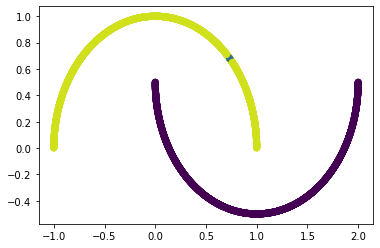

In [58]:
import time
from matplotlib import pyplot as plt

tic = time.perf_counter()
C,K = LUND(X, H)
toc = time.perf_counter()

if toc-tic<60:
    print('LUND run complete. Total time elapsed: '+ str(round(toc-tic))+ ' s.')
else:
    print('LUND run complete. Total time elapsed: '+ str(round((toc-tic)/60,2))+ ' minutes.')


plt.scatter(X[:,0], X[:,1], c=C)

Density calculation, 0% complete. Time Elapsed: 0 s.
Density calculated. Time Elapsed: 0 s.
Constructing graph and performing eigendecomposition for diffusion map...
Graph and Diffusion Map calculated. Time Elapsed: 4 s.
rho_t calculation, 0% complete. Time Elapsed: 0 s.
rho_t calculation complete. Time Elapsed: 1 s.
LUND labeling complete. Time Elapsed: 0 s.
LUND run complete. Total time elapsed: 8 s.


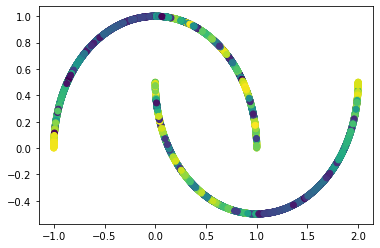

In [59]:
import time
from matplotlib import pyplot as plt

tic = time.perf_counter()
C,K = LUND_matlab(X, H)
toc = time.perf_counter()

if toc-tic<60:
    print('LUND run complete. Total time elapsed: '+ str(round(toc-tic))+ ' s.')
else:
    print('LUND run complete. Total time elapsed: '+ str(round((toc-tic)/60,2))+ ' minutes.')


plt.scatter(X[:,0], X[:,1], c=C)